In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from models import LinearAutoEncoder, ConvAutoEncoder, BaselineClassifier, LinearClassifier
from sklearn.metrics import f1_score

## Dataset Loading

In [2]:
import json, gzip

class MNIST_Dataset(Dataset):
    def __init__(self, json_data) -> None:
        self.features = [torch.FloatTensor(i['image']).view(28,28) for i in json_data]
        self.labels = [torch.LongTensor([i['label']]) for i in json_data]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = None
dev_dataset = None
test_dataset = None

with gzip.open('mnist_rowmajor.jsonl.gz') as file:
    trainval_data = []
    test_data = []

    for sample in [json.loads(line) for line in file]:
        sample['image'] = sample['image']
        if sample['split'] == 'train':
            trainval_data.append(sample)
        else:
            test_data.append(sample)

    train_dataset = MNIST_Dataset(trainval_data[:50000])
    dev_dataset = MNIST_Dataset(trainval_data[50000:])
    test_dataset = MNIST_Dataset(test_data)

In [3]:
BATCH_SIZE = 100

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Question 2b

### Training Function

In [15]:
def train_encoder(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer, max_epoch = 1):
    print(f'{"":<10} {"Train":^10} {"Dev":^10}')
    prev_loss = 2000000000
    # epoch loop
    for epoch in range(max_epoch):
        print(f'{f"Epoch {epoch+1}":<10}', end=' ')
        # 
        # training loop
        # 
        train_total_loss = 0
        total_num = 0
        for x, _ in train_dataloader:
            x = x.cuda()
            # forward pass
            pred_x = model.forward(x)
            # calculate gradients
            loss = criterion(pred_x, x)
            loss.backward()
            # update statistics
            train_total_loss += loss.item()
            total_num += 1
            # backward pass
            optimizer.step()
            optimizer.zero_grad()
        print(f'{train_total_loss/total_num:^10.5f}', end=' ')
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, _ in dev_dataloader:
            x = x.cuda()
            # forward pass
            pred_x = model.forward(x)
            # update statistics
            total_loss += criterion(pred_x, x).item()
            total_num += 1
        print(f'{total_loss/total_num:^10.5f}')
        # 
        # check convergence
        # 
        if train_total_loss > prev_loss:
            return
        prev_loss = train_total_loss

### Training

In [17]:
encoder_linear = LinearAutoEncoder().cuda()
train_encoder(encoder_linear, nn.BCELoss(), optim.Adam(encoder_linear.parameters(), lr=0.01), 100)

             Train       Dev    
Epoch 1     0.18957    0.14541  
Epoch 2     0.13492    0.12995  
Epoch 3     0.12662    0.12512  
Epoch 4     0.12366    0.12180  
Epoch 5     0.12170    0.12073  
Epoch 6     0.12092    0.12073  
Epoch 7     0.11983    0.11914  
Epoch 8     0.11917    0.11851  
Epoch 9     0.11889    0.11947  
Epoch 10    0.11830    0.11768  
Epoch 11    0.11791    0.11723  
Epoch 12    0.11780    0.11696  
Epoch 13    0.11739    0.11699  
Epoch 14    0.11727    0.11658  
Epoch 15    0.11693    0.11646  
Epoch 16    0.11694    0.11710  


In [19]:
encoder_conv = ConvAutoEncoder().cuda()
train_encoder(encoder_conv, nn.BCELoss(), optim.Adam(encoder_conv.parameters(), lr=0.01), 100)

             Train       Dev    
Epoch 1     0.18092    0.12769  
Epoch 2     0.12326    0.11906  
Epoch 3     0.11741    0.11680  
Epoch 4     0.11448    0.11645  
Epoch 5     0.11279    0.11359  
Epoch 6     0.11153    0.11109  
Epoch 7     0.11076    0.11076  
Epoch 8     0.10997    0.10968  
Epoch 9     0.10948    0.10914  
Epoch 10    0.10902    0.10845  
Epoch 11    0.10854    0.10808  
Epoch 12    0.10826    0.10796  
Epoch 13    0.10782    0.10884  
Epoch 14    0.10769    0.10722  
Epoch 15    0.10759    0.10807  
Epoch 16    0.10730    0.10681  
Epoch 17    0.10700    0.10703  
Epoch 18    0.10691    0.10737  
Epoch 19    0.10686    0.10728  
Epoch 20    0.10654    0.10638  
Epoch 21    0.10647    0.10621  
Epoch 22    0.10637    0.10664  
Epoch 23    0.10618    0.10667  
Epoch 24    0.10623    0.10571  


### Display

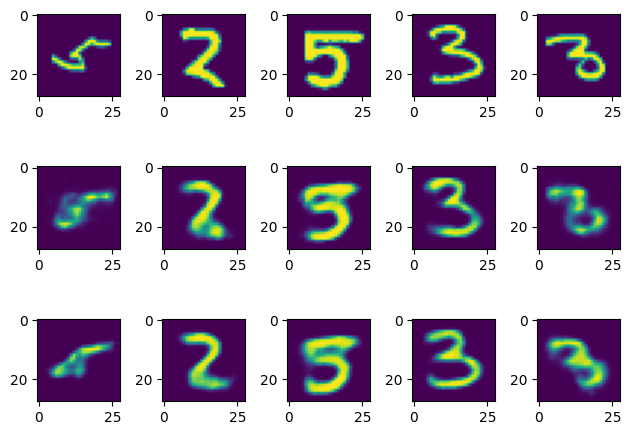

In [7]:
import random
fig, (row1, row2, row3) = plt.subplots(3, 5)

for i in range(5):
    x = dev_dataset[random.randint(0,10000-1)][0].cuda()
    x_pred_linear = encoder_linear.forward(x, detach=True).view(28,28)
    x_pred_conv = encoder_conv.forward(x, detach=True).view(28,28)

    row1[i].imshow(x.cpu())
    row2[i].imshow(x_pred_linear.cpu())
    row3[i].imshow(x_pred_conv.cpu())

plt.tight_layout()
plt.show()

## Question 2c

### Training Functions

In [26]:
def train_baseline(model: BaselineClassifier, criterion: nn.Module, num_epoch = 1):
    print(f'{"":<10} {"Train":^10} {"Test":^10}')
    prev_loss = 2000000000
    # epoch loop
    for epoch in range(num_epoch):
        print(f'{f"Epoch {epoch+1}":<10}', end=' ')
        # 
        # training loop
        # 
        train_total_loss = 0
        total_num = 0
        for x, y in train_dataloader:
            x = x.cuda()
            y = y.view(-1)
            # forward pass
            pred_y = model.forward(x)
            # update statistics
            train_total_loss += criterion(pred_y, y).item()
            total_num += 1
            # backward pass
            for y_i in y:
                model.w[y_i] += 1
        print(f'{train_total_loss/total_num:^10.5f}', end=' ')
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in test_dataloader:
            x = x.cuda()
            y = y.view(-1)
            # forward pass
            pred_y = model.forward(x)
            # update statistics
            total_loss += criterion(pred_y, y).item()
            total_num += 1
        print(f'{total_loss/total_num:^10.5f}')
        # 
        # check convergence
        # 
        if abs(train_total_loss - prev_loss) < 1:
            return
        prev_loss = train_total_loss

In [27]:
def train_classifier(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer, max_epoch = 1):
    print(f'{"":<10} {"Train":^10} {"Test":^10}')
    prev_loss = 2000000000
    # epoch loop
    for epoch in range(max_epoch):
        print(f'{f"Epoch {epoch+1}":<10}', end=' ')
        # 
        # training loop
        # 
        train_total_loss = 0
        total_num = 0
        for x, y in train_dataloader:
            x = x.cuda()
            y = y.view(-1).cuda()
            # forward pass
            z = encoder_linear.forward(x).detach()
            pred_y = model.forward(z)
            # calculate gradients
            loss = criterion(pred_y, y)
            loss.backward()
            # update statistics
            train_total_loss += loss.item()
            total_num += 1
            # backward pass
            optimizer.step()
            optimizer.zero_grad()
        print(f'{train_total_loss/total_num:^10.5f}', end=' ')
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in test_dataloader:
            x = x.cuda()
            y = y.view(-1).cuda()
            # forward pass
            z = encoder_linear.forward(x).detach()
            pred_y = model.forward(z)
            # update statistics
            total_loss += criterion(pred_y, y).item()
            total_num += 1
        print(f'{total_loss/total_num:^10.5f}')
        # 
        # check convergence
        # 
        if abs(train_total_loss - prev_loss) < 1:
            return
        prev_loss = train_total_loss

### Training

In [28]:
classifier_base = BaselineClassifier().cuda()
train_baseline(classifier_base, nn.CrossEntropyLoss(), 100)

             Train       Test   
Epoch 1    

 2.34993    2.34765  
Epoch 2     2.34925    2.34765  


In [29]:
classifier_linear = LinearClassifier().cuda()
train_classifier(classifier_linear, nn.CrossEntropyLoss(), optim.Adam(classifier_linear.parameters(), lr=0.001), 100)

             Train       Test   
Epoch 1    

 0.46709    0.26825  
Epoch 2     0.25471    0.24272  
Epoch 3     0.22092    0.22142  
Epoch 4     0.20127    0.20025  
Epoch 5     0.18750    0.19418  
Epoch 6     0.17413    0.19437  
Epoch 7     0.16643    0.18214  
Epoch 8     0.15734    0.18469  
Epoch 9     0.15185    0.18850  
Epoch 10    0.14702    0.19013  
Epoch 11    0.14245    0.17887  
Epoch 12    0.13515    0.17601  
Epoch 13    0.13341    0.17866  
